# _bare soil evap:_ Comparison between SWB 1.0 and SWB 2.0 #

## Preliminaries ##

### Bring in Python modules ###

In [1]:
%matplotlib inline

import os
import gdal
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from netCDF4 import Dataset as netcdf_dataset
import numpy as np
import numpy.ma as ma
import pandas as pd
%run plot_and_table_functions.py

### Set variables that determine the model output being compared ###

In [2]:
SWB2_param_name             = "bare_soil_evaporation"
SWB2_grid_dimensions        = "346_by_400"
SWB2_path                   = "../swb2"

SWB2_start_year      = "2012"
SWB2_stop_year       = "2013"
SWB2_start_date      = "2012-01-01"
SWB2_stop_date       = "2013-12-31"

SWB2_file_prefix     = "central_sands_"
Simulation_length_in_years = 2.0

SWB_param_name             = "BARE_SOIL_EVAP"
SWB_path                   = "../swb1/output/annual"

SWB_start_year      = "2012"
SWB_stop_year       = "2013"

Plot_title_param           = "Bare Soil Evaporation"
Plot_title_units           = ", in Inches"

### Open and read model output files ###

In [3]:
# Define the pathname to the SWB2 output file. 
fname_swb2 = os.path.join( SWB2_path, "output", SWB2_file_prefix + SWB2_param_name + '__'
                     + SWB2_start_date 
                     + '_to_' + SWB2_stop_date
                     + '__' + SWB2_grid_dimensions + '.nc' )
dataset_swb2 = netcdf_dataset( fname_swb2 )
if dataset_swb2 is None:
    print('Could not open SWB 2.0 NetCDF grid file')
    sys.exit(1)

yearcount = 0
SWB_values = None
    
for year in range(int(SWB_start_year), int(SWB_stop_year) + 1):
    yearcount += 1
    # Define pathname to the SWB output file
    fname_swb = os.path.join( SWB_path, 'swb__' + SWB_param_name + '_'
                     + str( year )
                     + '_SUM.asc' )
    dataset_swb = gdal.Open( fname_swb )
    if dataset_swb is None:
        print('Could not open SWB data grid')
        os.sys.exit(1)
    
    if SWB_values is None:
        # the SWB output comes in as an Arc ASCII grid, with "-9999" values denoting the
        # areas of inactive model domain; as with the previous grid, must deal with these
        # before doing any further analysis. numpy "masked array" does what we need.
        SWB_values = dataset_swb.ReadAsArray()
        SWB_values = ma.masked_where( SWB_values < 0, SWB_values )
    else:
        tempvals = dataset_swb.ReadAsArray()
        tempvals = ma.masked_where( tempvals < 0, tempvals )
        SWB_values += tempvals

SWB_values /= float( yearcount )

# Define the pathname to the landuse Arc ASCII file output by SWB
fname_lu = os.path.join(SWB2_path, 'output', 'Landuse_land_cover__as_read_into_SWB.asc' )
dataset_lu = gdal.Open( fname_lu )
if dataset_lu is None:
    print('Could not open landuse grid')
    quit
    
# Define the pathname to the SWB landuse lookup table
fname_lu_table = os.path.join(SWB2_path, 'std_input', 'Landuse_lookup_CDL.txt' )    
lu_table = pd.read_table( fname_lu_table )    

## Plots and Comparisons ##
### Plot of Soil-Water-Balance Model output ###

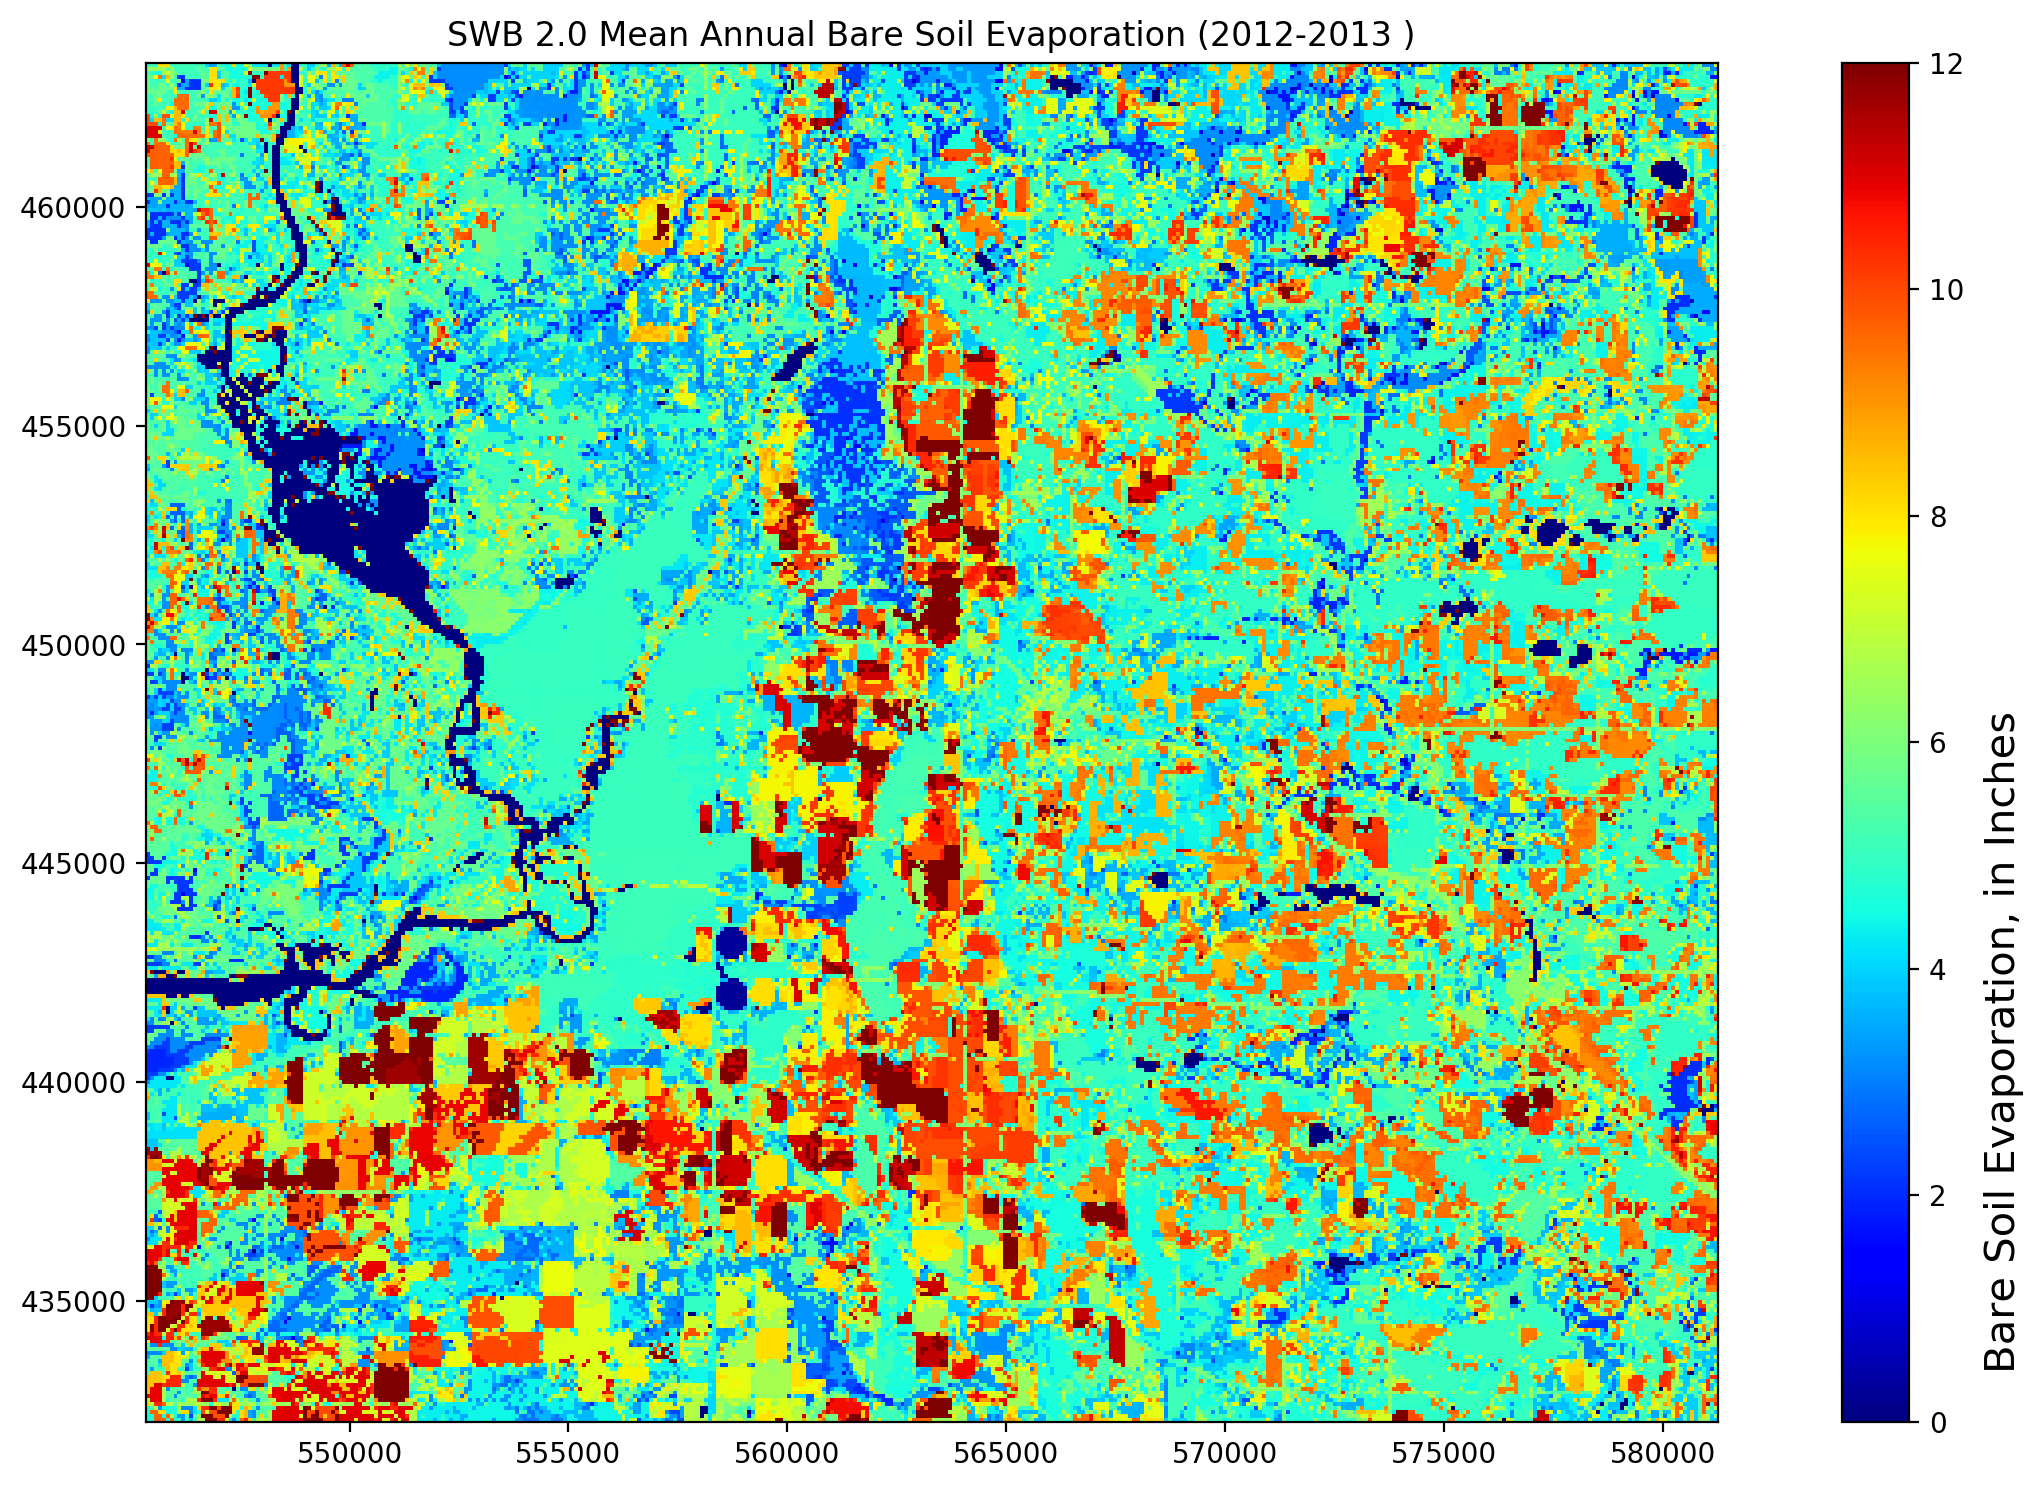

In [4]:
SWB2_values = dataset_swb2.variables[ SWB2_param_name ][:, :, :]
# the netCDF values come in with not-a-number (NaN) values in the inactive cells;
# need to deal with these NaNs before doing any processing
SWB2_values = ma.masked_where( np.isnan(SWB2_values), SWB2_values ) 

# sum daily model outputs over the time dimension (axis "0")
SWB2_values = SWB2_values.sum(axis=0) / Simulation_length_in_years

x = dataset_swb2.variables['x'][:]
y = dataset_swb2.variables['y'][:]

make_plot(x=x, y=y, var=SWB2_values, 
          title="SWB 2.0 Mean Annual " + Plot_title_param + " (" 
          + SWB2_start_year + "-" + SWB2_stop_year + " )",
          barlabel=Plot_title_param + Plot_title_units, minz=0., maxz=12. )

### Plot of SWB 1.0 Model output ###

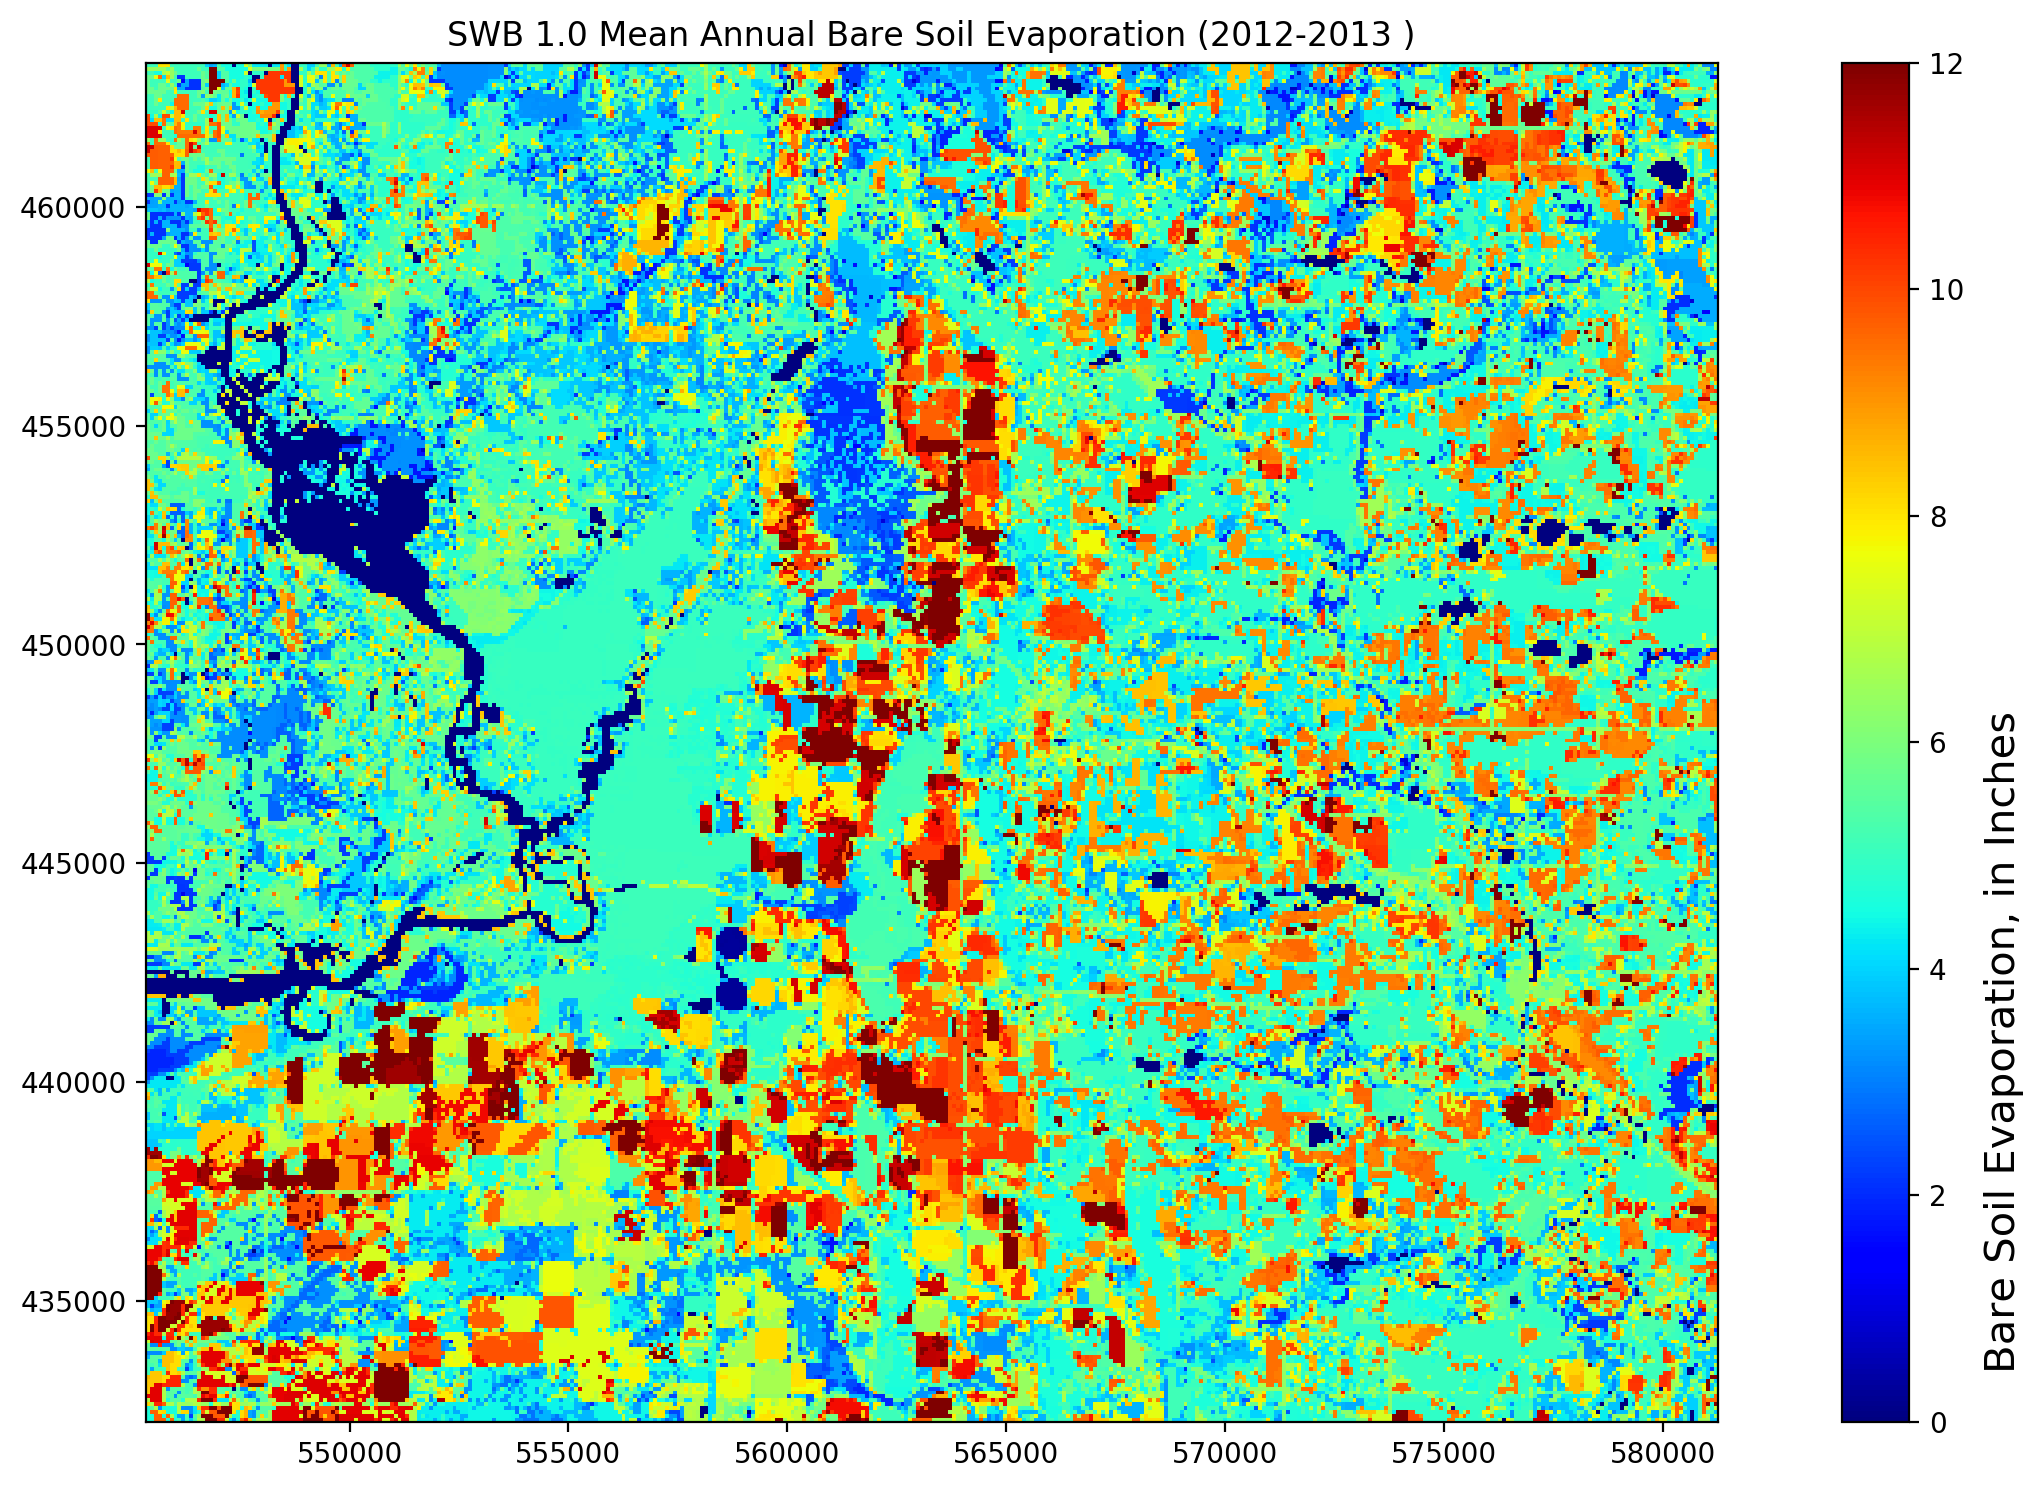

In [6]:
make_plot(x=x, y=y, var=SWB_values,
          title="SWB 1.0 Mean Annual " + Plot_title_param + " (" 
          + SWB_start_year + "-" + SWB_stop_year + " )",
          barlabel=Plot_title_param + Plot_title_units, minz=0., maxz=12. )

### Plot of differences: SWB 2.0 output minus SWB 1.0 output ###

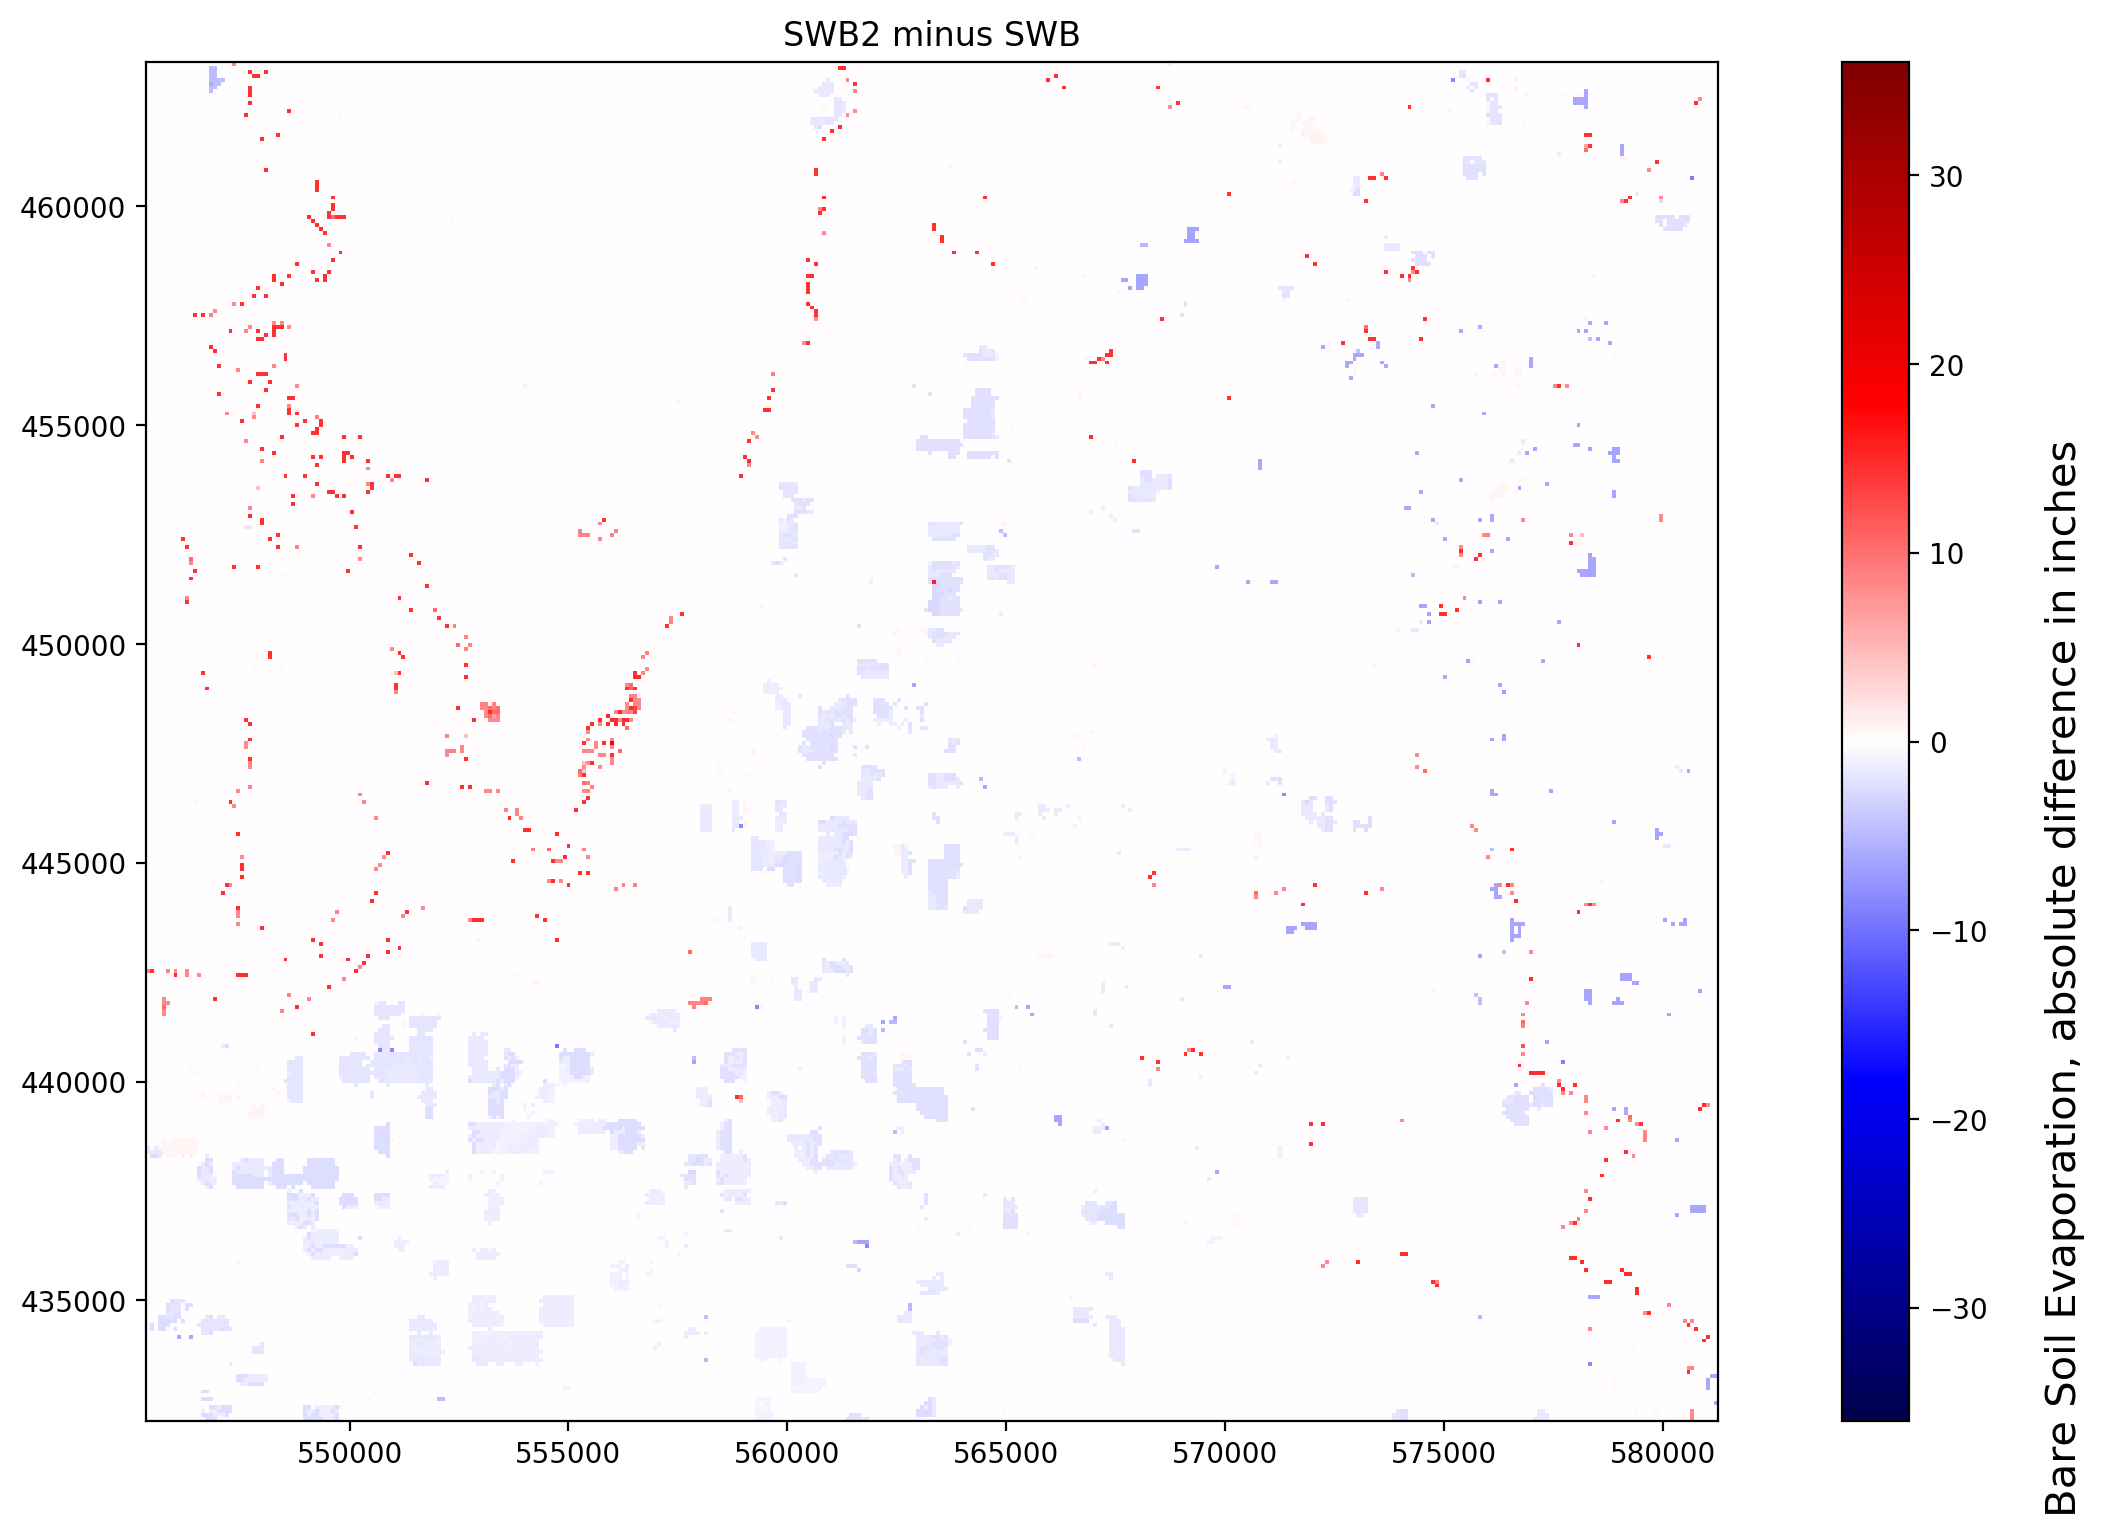

In [6]:
diff = SWB2_values - SWB_values
make_diffplot(x=x, y=y, var=diff,
          title="SWB2 minus SWB",
          barlabel=Plot_title_param + ", absolute difference in inches" )

### Plot of SWB 2.0 and SWB 1.0 model outputs ###

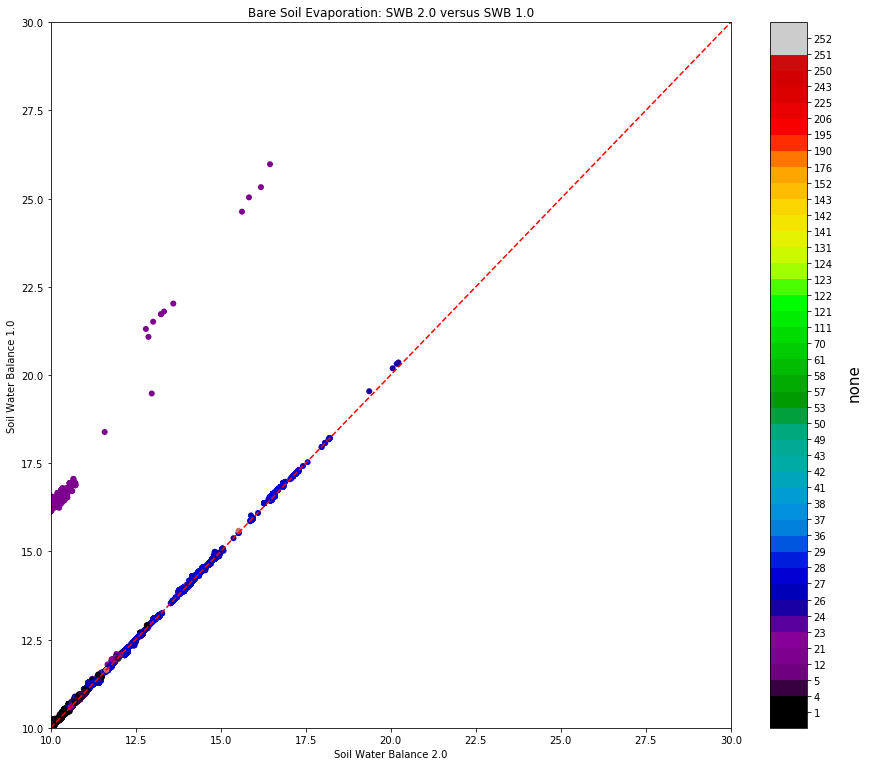

In [7]:
lu = dataset_lu.ReadAsArray()
lu = ma.masked_where( lu <= 0, lu )
lu_vals=np.unique( lu.flatten() )
N=lu_vals.count()
make_scatter(x=SWB2_values, y=SWB_values, color=lu, title=Plot_title_param 
             + ": SWB 2.0 versus SWB 1.0", xlab="Soil Water Balance 2.0",
             ylab="Soil Water Balance 1.0",
            xmin=10, ymin=10, xmax=30, ymax=30, cmap=discrete_cmap(N, "nipy_spectral"))

_Comments:_ The color coding above corresponds to the landuse code from the LU_code field in the landuse lookup table. Linear strings of points that do not fall on the 1:1 slope line appear to be caused by mismatches in grid cell coverage and resolution in the various input files.

### Plot of landuse as read in by SWB ###

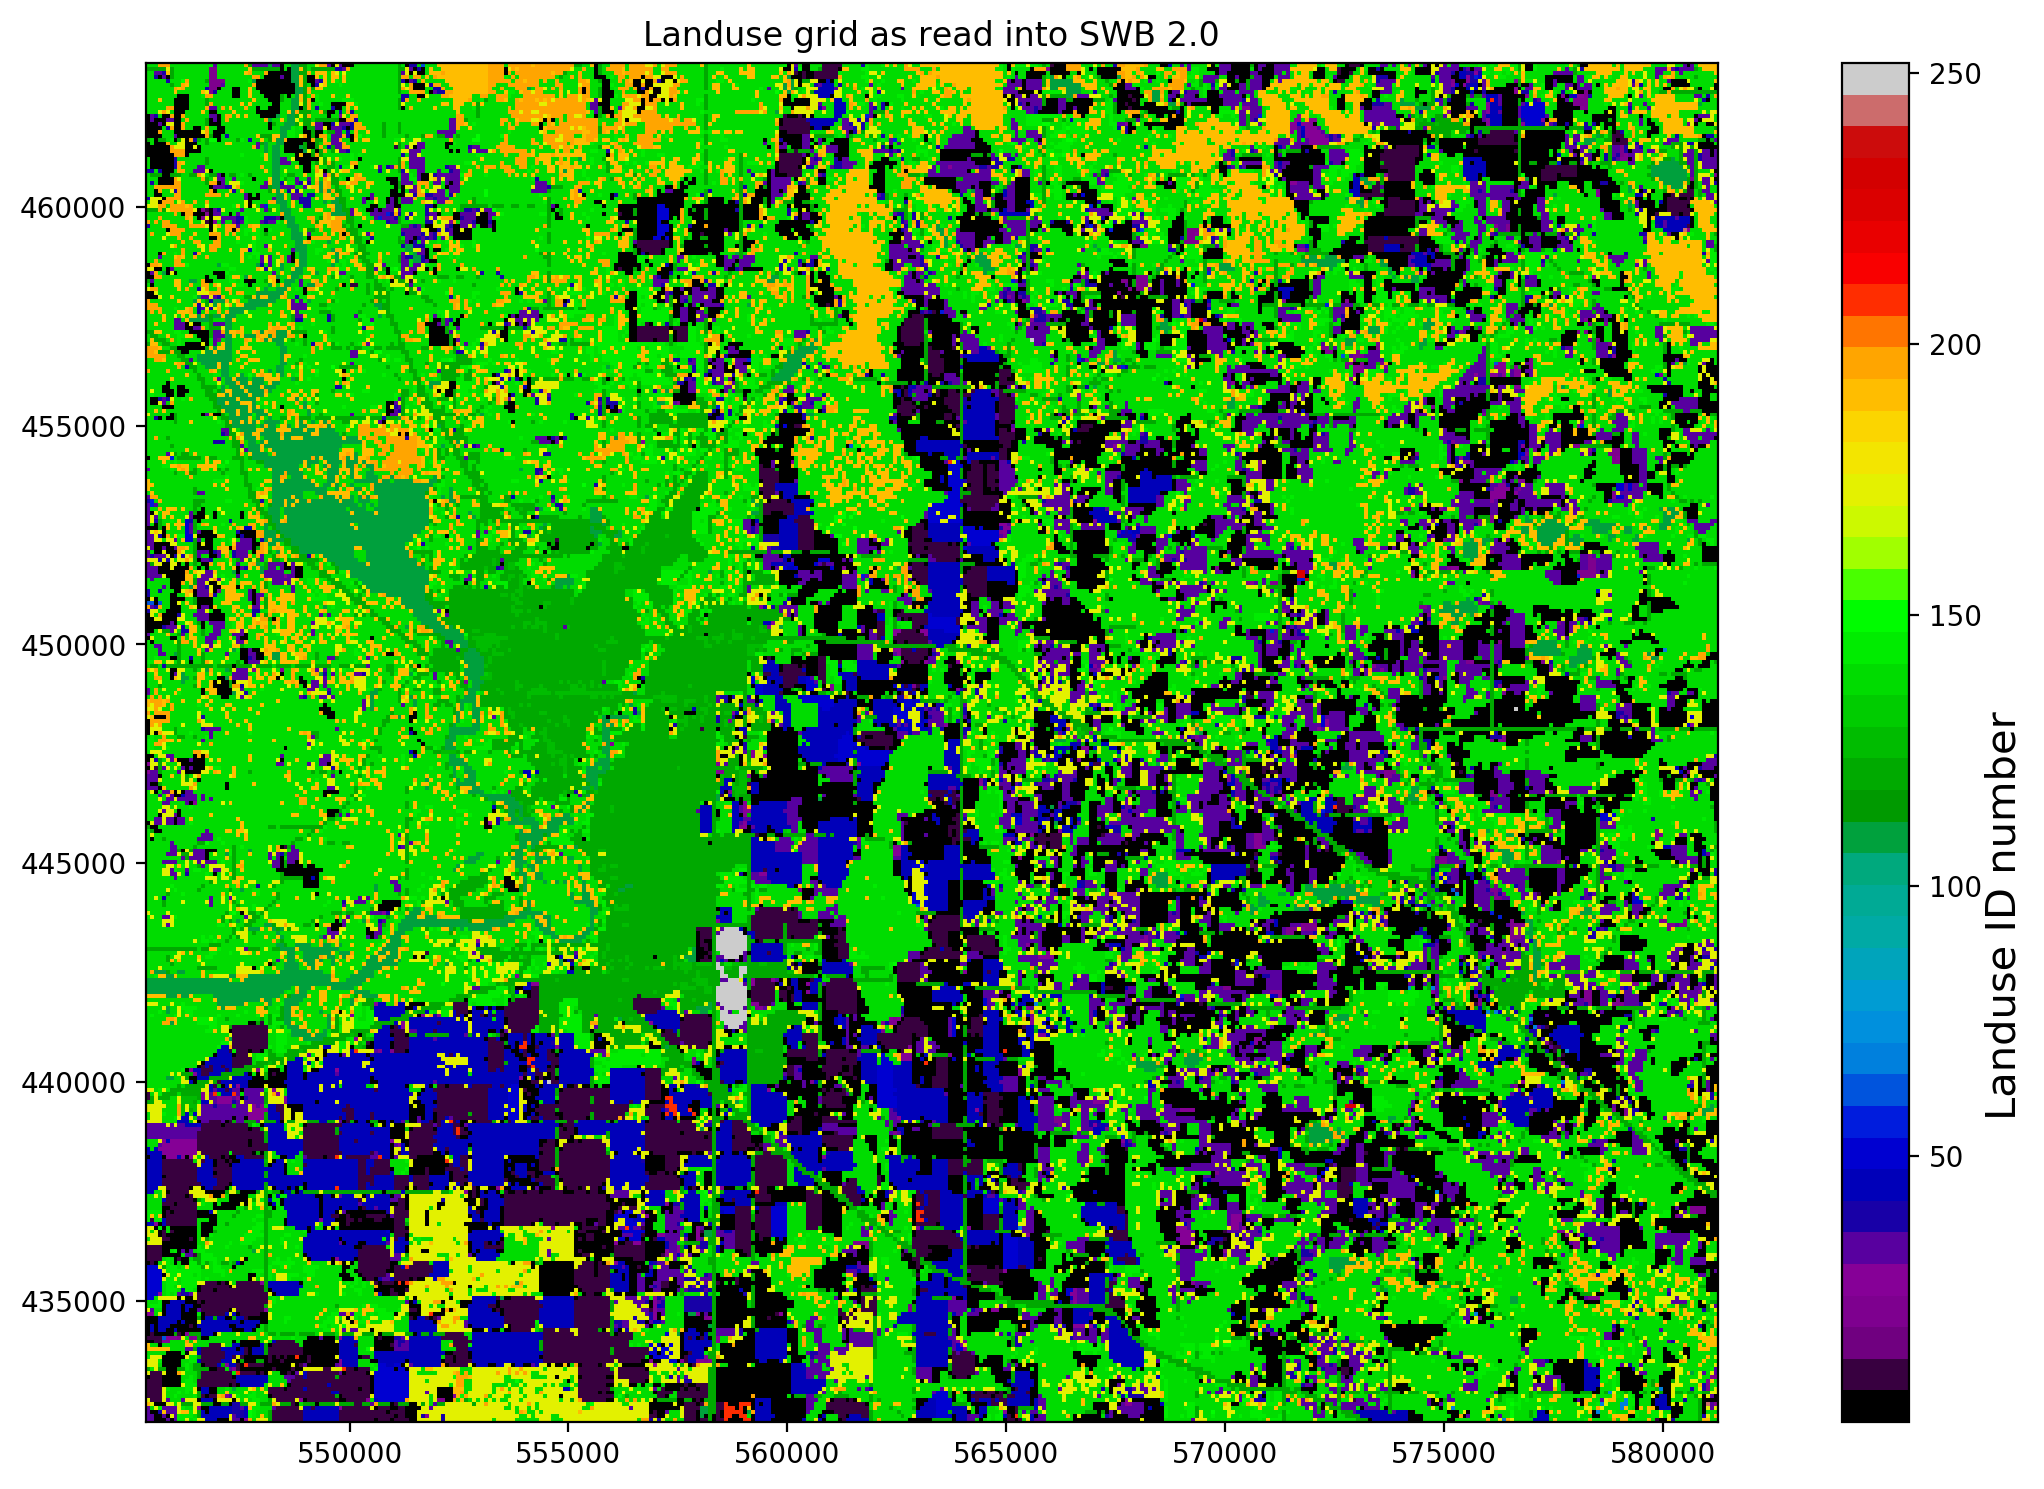

In [8]:
cmap = discrete_cmap(N, "nipy_spectral")
make_plot(x=x, y=y, var=lu,
          title="Landuse grid as read into SWB 2.0",
          barlabel="Landuse ID number",
          cmap=cmap)

### Table of model differences by landuse code ###

LU:  Corn (land-use code 1, n=20181)


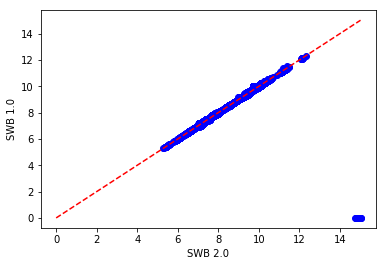

LU:  Sorghum (land-use code 4, n=23)


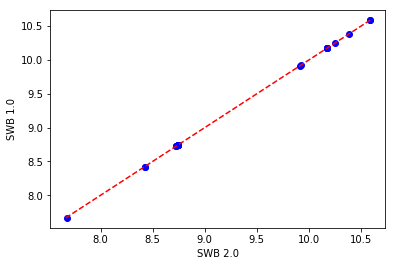

LU:  Soybeans (land-use code 5, n=2534)


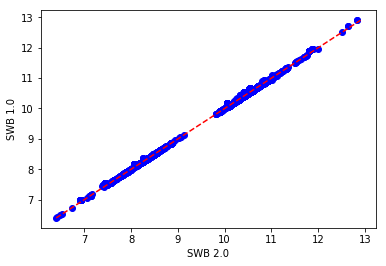

LU:  Sweet Corn (land-use code 12, n=5957)


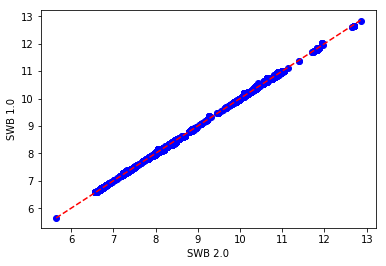

LU:  Barley (land-use code 21, n=34)


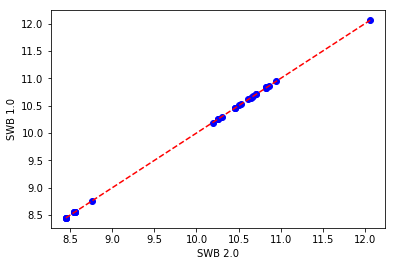

LU:  Spring Wheat (land-use code 23, n=7)


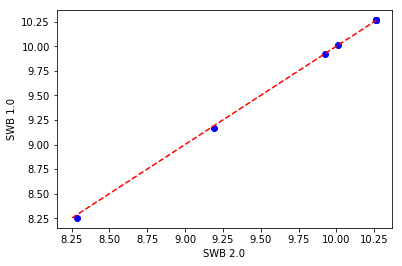

LU:  Winter Wheat (land-use code 24, n=302)


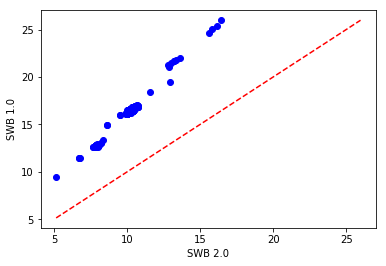

LU:  Dbl Crop WinWht/Soybeans (land-use code 26, n=5)


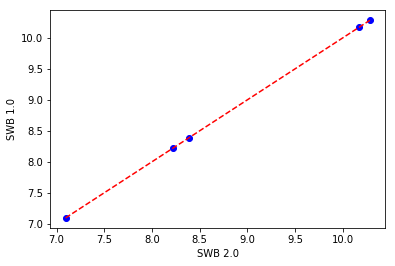

LU:  Rye (land-use code 27, n=358)


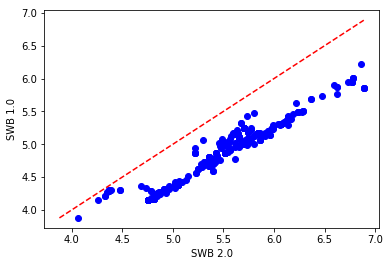

LU:  Oats (land-use code 28, n=172)


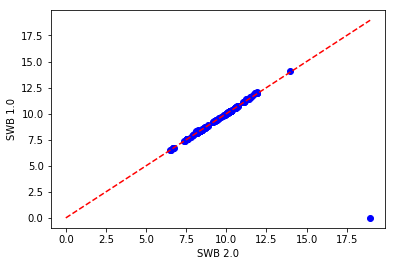

LU:  Millet (land-use code 29, n=2)


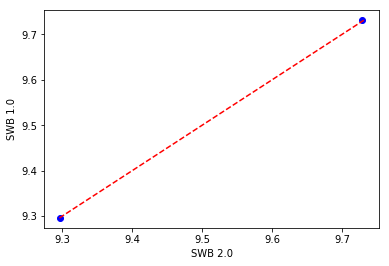

LU:  Alfalfa (land-use code 36, n=10437)


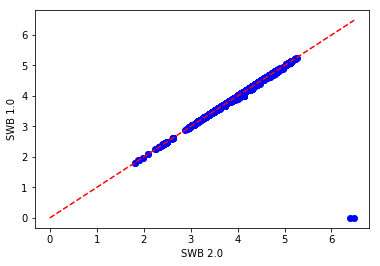

LU:  Other Hay/Non Alfalfa (land-use code 37, n=1413)


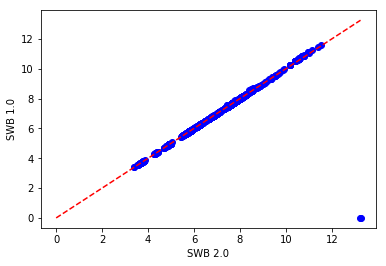

LU:  Camelina (land-use code 38, n=39)


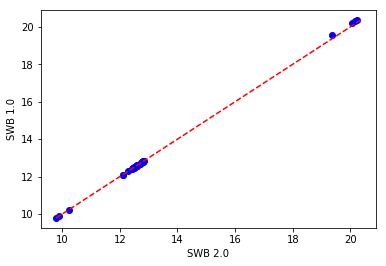

LU:  Sugarbeets (land-use code 41, n=8)


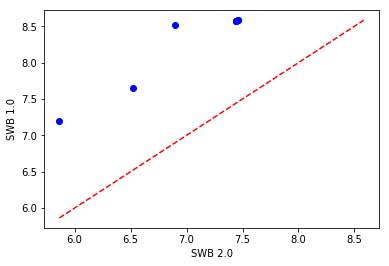

LU:  Dry Beans (land-use code 42, n=3096)


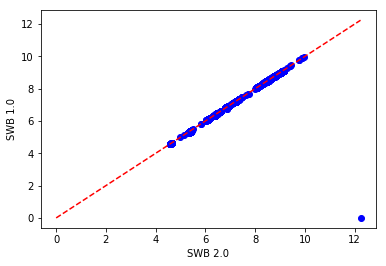

LU:  Potatoes (land-use code 43, n=4943)


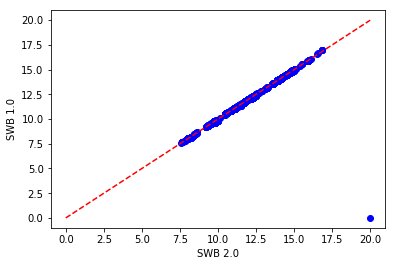

LU:  Onions (land-use code 49, n=1)


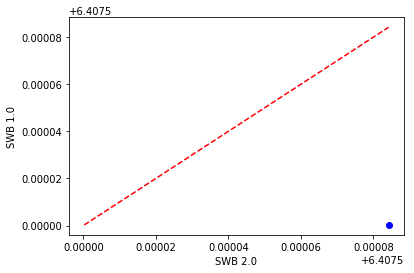

LU:  Cucumbers (land-use code 50, n=1)


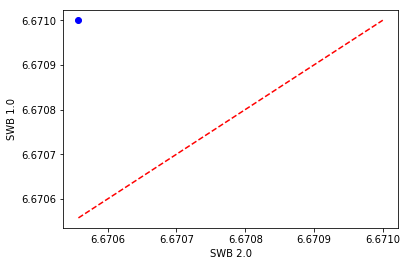

LU:  Peas (land-use code 53, n=757)


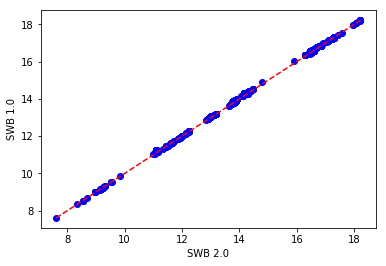

LU:  Herbs (land-use code 57, n=4)


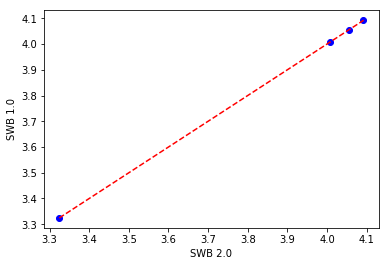

LU:  Clover/Wildflowers (land-use code 58, n=34)


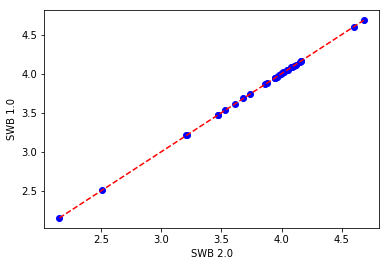

LU:  Fallow/Idle Cropland (land-use code 61, n=12)


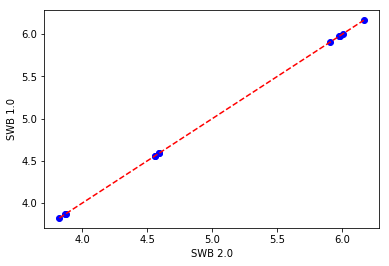

LU:  Christmas Trees (land-use code 70, n=26)


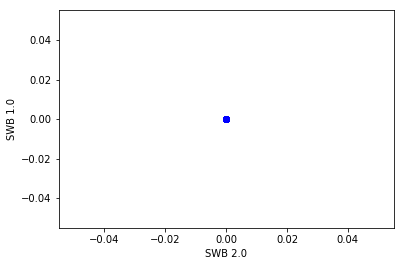

LU:  Open Water (land-use code 111, n=3447)


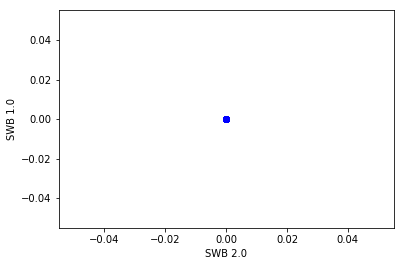

LU:  Developed/Open Space (land-use code 121, n=7482)


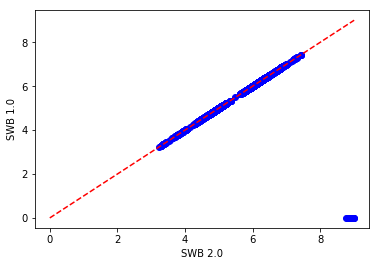

LU:  Developed/Low Intensity (land-use code 122, n=4114)


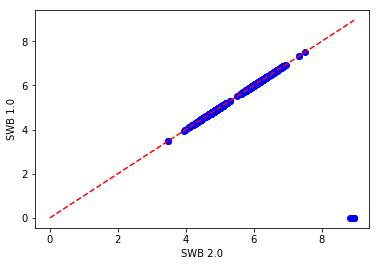

LU:  Developed/Medium Intensity (land-use code 123, n=1018)


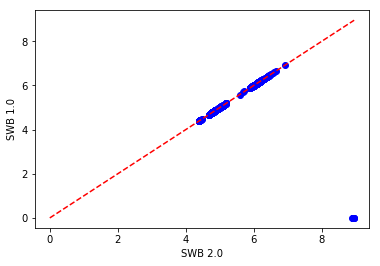

LU:  Developed/High Intensity (land-use code 124, n=472)


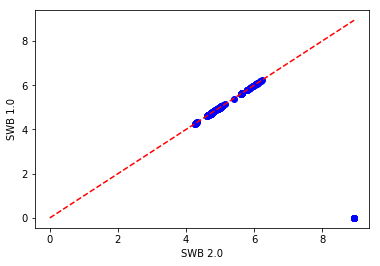

LU:  Barren (land-use code 131, n=93)


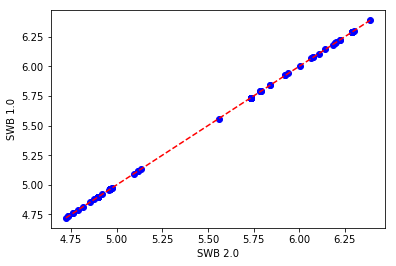

LU:  Deciduous Forest (land-use code 141, n=45251)


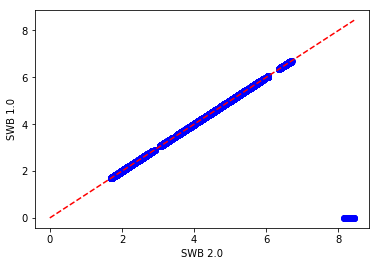

LU:  Evergreen Forest (land-use code 142, n=3879)


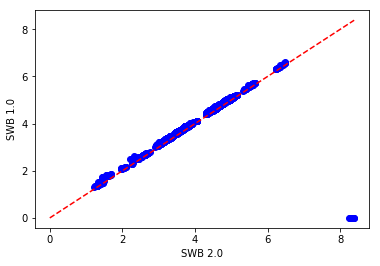

LU:  Mixed Forest (land-use code 143, n=1197)


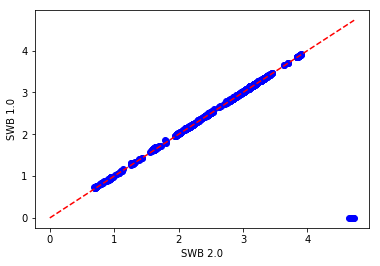

LU:  Shrubland (land-use code 152, n=189)


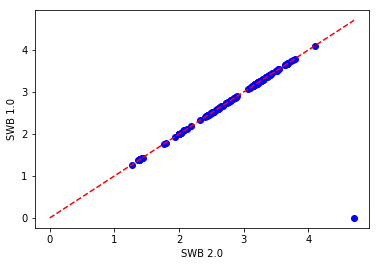

LU:  Grass/Pasture (land-use code 176, n=9480)


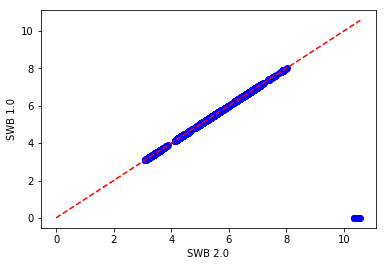

LU:  Woody Wetlands (land-use code 190, n=8180)


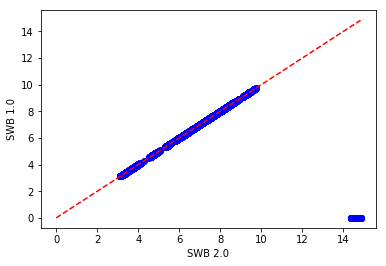

LU:  Herbaceous Wetlands (land-use code 195, n=3025)


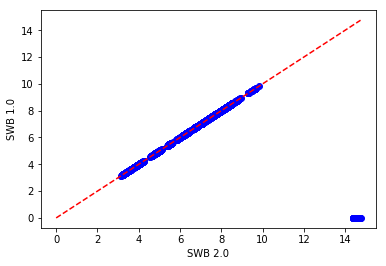

LU:  Carrots (land-use code 206, n=71)


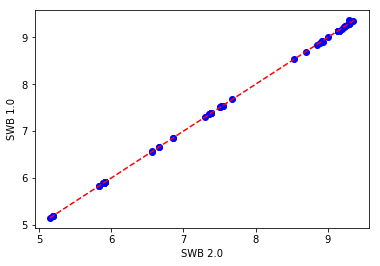

LU:  Dbl Crop WinWht/Corn (land-use code 225, n=9)


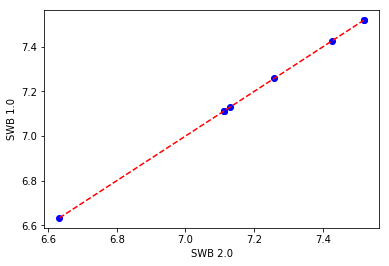

LU:  Cabbage (land-use code 243, n=2)


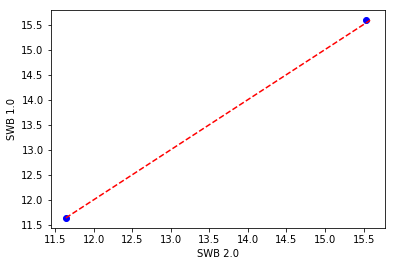

LU:  Cranberries (land-use code 250, n=3)


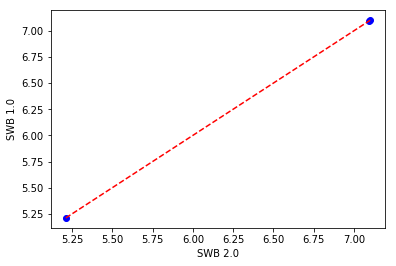

LU: Waste_disposal_fallow (land-use code 251, n=31)


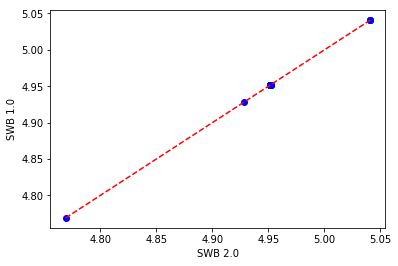

LU: Waste_disposal_grass (land-use code 252, n=111)


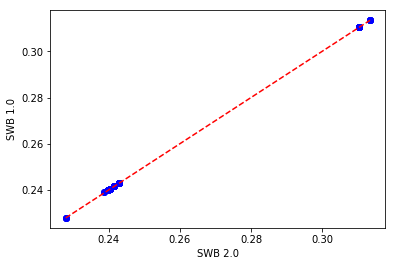

,Code,Description,Count,SWB 2.0,SWB 1.0,Difference
0,1,Corn,20181,8.879715,8.874408,0.005307
1,4,Sorghum,23,9.315598,9.314890,0.000709
2,5,Soybeans,2534,9.588387,9.596304,-0.007916
3,12,Sweet Corn,5957,8.922903,8.920766,0.002137
4,21,Barley,34,9.913027,9.912823,0.000204
5,23,Spring Wheat,7,9.742709,9.735785,0.006924
6,24,Winter Wheat,302,10.056666,16.201794,-6.145127
7,26,Dbl Crop WinWht/Soybeans,5,8.831447,8.831202,0.000245
8,27,Rye,358,5.509057,4.888362,0.620695
9,28,Oats,172,9.494187,9.393593,0.100595


In [8]:
np.unique(lu)
lu_descriptions=lu_table['Description']
lu_lookup_values=lu_table['LU_Code']
make_comparison_table( x=SWB2_values, y=SWB_values, factor=lu, 
                       description=lu_descriptions,
                       lookup_vals=lu_lookup_values,
                       xlab='SWB 2.0', ylab='SWB 1.0')